# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

# Step 1: Read in Data

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_columns', 200)
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from statsmodels.formula.api import ols

from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression


df = pd.read_csv('Resources/kc_house_data_train.csv', index_col=0)
df = df.drop(['id'], axis=1)

In [2]:
#adjusting bedrooms outliers 
df['bedrooms'] = df['bedrooms'].apply(lambda x : 9 if x > 9 else x)
#np.where(df['my_channel'] > 20000, 0, df['my_channel'])

In [3]:
#Run below cell for heatmap of correlations

In [4]:
# #create a heatmap to visualize the correlations
# fig, ax = plt.subplots(figsize=(25,15)) # figsize to make larger
# corr = df.corr()

# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# # fix for matplotlib bug that cuts off top/bottom of seaborn viz
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values

# plt.show()

# Step 2: EDA
### Initial Findings and planning
- **highest correlations:** 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15' (check for outliers and extreme values)
    - sqft_living seems like a better predictor
- **suprisingly low correlations:** 'bedrooms', 'waterfront', 'view', 'condition', 'renovated_0' (manipulate to create higher correlations)
- check out for outliers in price by sqft
- 33 bedrooms outlier
- bin `condition` into 3 categories: 1/2, 3/4, and 5
- bin `view` into 3 categories: 0, 1&2, 3, 4 (create poly?)
- `grade` poly?
- dummy code zip codes
- check out distances from Seattle city center with `lat` and `long`
- viz for floors
- waterfront: t-test

In [5]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [6]:
#changing date format workable month/year

df['yr_sold'] = pd.to_datetime(df['date'].str.slice(0,8), format='%Y%m%d', errors='ignore').dt.year
df['month_sold'] = pd.to_datetime(df['date'].str.slice(0,8), format='%Y%m%d', errors='ignore').dt.month
df.drop('date',axis=1,inplace=True)

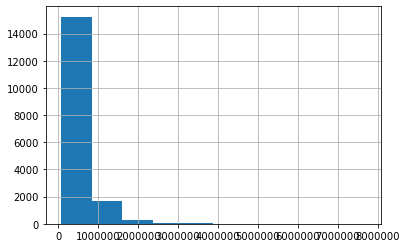

In [7]:
df.price.hist()

**almost normal: price by sqft, sqft_living, yr_built**

In [8]:
#log:sqft_above, sqft_living, sqft_living15, 

In [9]:
# Run below cell for histograms

In [10]:
# df.hist(bins=50, figsize=(20,15))
# plt.show()

Bin groups: Condition (1&2, 3&4, 5); View (0, 1&2, 3&4)

polynomial grade,  `df['grade_exp'] = np.exp(df['grade'])`, view(?)

waterfront: t-test

In [11]:
#Run below cell for pairplot

In [12]:
# sns.pairplot(df[['bathrooms', 'bedrooms', 'lat', 'long', 'month_sold', 'sqft_above', 'sqft_basement', 'sqft_living', 'grade', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'yr_built', 'yr_renovated', 'price']], corner=True)


In [13]:
# # Bar plots of categorical data
# #zipcode explored later
# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

# categoricals = ['condition', 'floors', 'grade', 'month_sold', 'yr_sold', 'view', 'waterfront']

# for col, ax in zip(categoricals, axes.flatten()):
#     (df.groupby(col)               # group values together by column of interest
#          .mean()['price']        # take the mean of the saleprice for each group
#          .plot
#          .bar(ax=ax))                # create a bar graph on the ax    
#     ax.set_title(col)                # Make the title the name of the column
# fig.tight_layout()

In [14]:
list(df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'yr_sold',
 'month_sold']

In [15]:
df.info()
# all dtypes are ints and floats, one object: 'date'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
price            17290 non-null float64
bedrooms         17290 non-null int64
bathrooms        17290 non-null float64
sqft_living      17290 non-null int64
sqft_lot         17290 non-null int64
floors           17290 non-null float64
waterfront       17290 non-null int64
view             17290 non-null int64
condition        17290 non-null int64
grade            17290 non-null int64
sqft_above       17290 non-null int64
sqft_basement    17290 non-null int64
yr_built         17290 non-null int64
yr_renovated     17290 non-null int64
zipcode          17290 non-null int64
lat              17290 non-null float64
long             17290 non-null float64
sqft_living15    17290 non-null int64
sqft_lot15       17290 non-null int64
yr_sold          17290 non-null int64
month_sold       17290 non-null int64
dtypes: float64(5), int64(16)
memory usage: 2.9 MB


In [16]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold
count,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,5.407395e+05,3.370792,2.111943,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.792019,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824,2014.323135,6.570561
std,3.733190e+05,0.910916,0.770476,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343516,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583,0.467687,3.116999
min,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000,2014.000000,1.000000
25%,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000,2014.000000,4.000000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000,2014.000000,6.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000,2015.000000,9.000000
max,7.700000e+06,9.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000,2015.000000,12.000000


# Investigation

### Outcome Variable: Price
may keep `price` as-is -- perhaps bring outliers down to 6000000? Let's see how models do with both options

NOTE: may help to normalize/scale/log

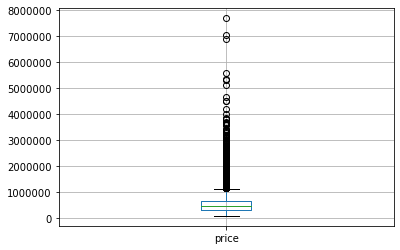

In [17]:
df.boxplot(['price'])

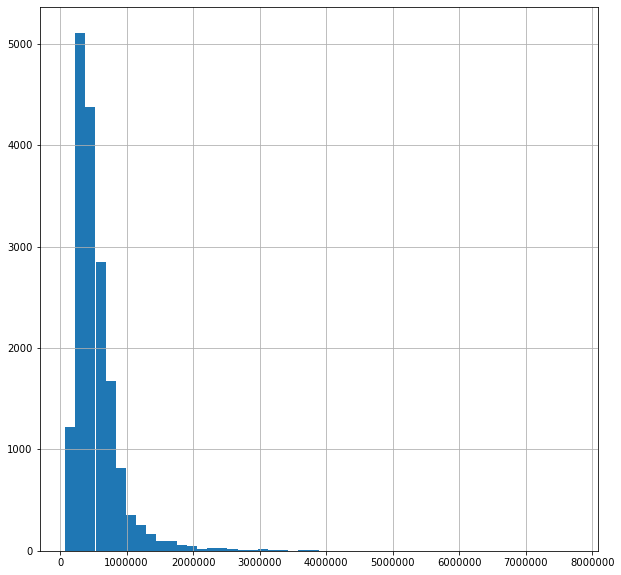

In [18]:
df.price.hist(bins=50, figsize=(10,10))
plt.show()

#### Price by square feet (checking for outliers)

In [19]:
## Creating new feature: price per square feet
df['price_by_sqft'] = df.price/df.sqft_living

In [20]:
#Checking out highest priced homes
df.loc[df.price > 5000000].sort_values('price_by_sqft')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,price_by_sqft
2232,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345,2014,8,605.434783
14668,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788,2014,10,638.052434
10366,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,2014,10,639.004149
1979,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750,2015,4,668.750000
7519,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730,2014,9,696.157735
6903,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449,2014,6,703.436255
5039,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619,2015,4,717.185386


In [21]:
df.loc[df.price < 1000000].sort_values('price_by_sqft').head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,price_by_sqft
2709,148900.0,4,1.75,1700,6000,1.0,0,0,3,7,1700,0,1967,0,98002,47.3252,-122.208,1280,6000,2014,12,87.588235
11036,149000.0,3,1.00,1700,8645,1.0,0,0,3,6,1700,0,1955,0,98146,47.4899,-122.337,1500,7980,2014,5,87.647059
5589,257000.0,5,2.75,2930,10148,2.0,0,0,3,9,2930,0,2002,0,98059,47.4887,-122.145,2930,8425,2014,10,87.713311
12735,110000.0,3,1.00,1250,53143,1.0,0,0,5,6,1250,0,1945,0,98038,47.4235,-122.051,1820,217800,2014,5,88.000000
8877,250000.0,3,1.50,2840,10182,1.0,0,0,3,8,1510,1330,1951,0,98056,47.5240,-122.200,2210,9669,2015,1,88.028169


In [22]:
df.sort_values('price_by_sqft')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,price_by_sqft
2709,148900.0,4,1.75,1700,6000,1.0,0,0,3,7,1700,0,1967,0,98002,47.3252,-122.208,1280,6000,2014,12,87.588235
11036,149000.0,3,1.00,1700,8645,1.0,0,0,3,6,1700,0,1955,0,98146,47.4899,-122.337,1500,7980,2014,5,87.647059
5589,257000.0,5,2.75,2930,10148,2.0,0,0,3,9,2930,0,2002,0,98059,47.4887,-122.145,2930,8425,2014,10,87.713311
12735,110000.0,3,1.00,1250,53143,1.0,0,0,5,6,1250,0,1945,0,98038,47.4235,-122.051,1820,217800,2014,5,88.000000
8877,250000.0,3,1.50,2840,10182,1.0,0,0,3,8,1510,1330,1951,0,98056,47.5240,-122.200,2210,9669,2015,1,88.028169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13909,903000.0,2,1.50,1140,7800,1.0,0,0,4,6,1140,0,1947,0,98004,47.6142,-122.209,2020,7800,2014,12,792.105263
3748,325000.0,1,0.75,410,8636,1.0,0,0,2,4,410,0,1953,0,98146,47.5077,-122.357,1190,8636,2015,1,792.682927
6471,3400000.0,4,4.00,4260,11765,2.0,0,0,3,11,3280,980,1939,2010,98112,47.6380,-122.288,4260,10408,2015,5,798.122066
3874,2400000.0,3,2.25,3000,11665,1.5,1,4,3,11,3000,0,2001,0,98075,47.5884,-122.086,3000,15959,2014,5,800.000000


In [23]:
#df = df.drop(['price_by_sqft'], axis=1)

## Zipcode 
create dummy codes in feature creation

In [24]:
df.zipcode.value_counts().count()

70

In [25]:
#DF of price and zipcode
df[['price', 'zipcode']].sort_values('price')

## Next step: get mean of price for each zipcode

,price,zipcode
9060,75000.0,98022
4869,78000.0,98168
9193,80000.0,98014
15956,82000.0,98146
1269,82500.0,98168
...,...,...
1979,5350000.0,98004
2232,5570000.0,98039
7519,6885000.0,98039
6903,7062500.0,98004


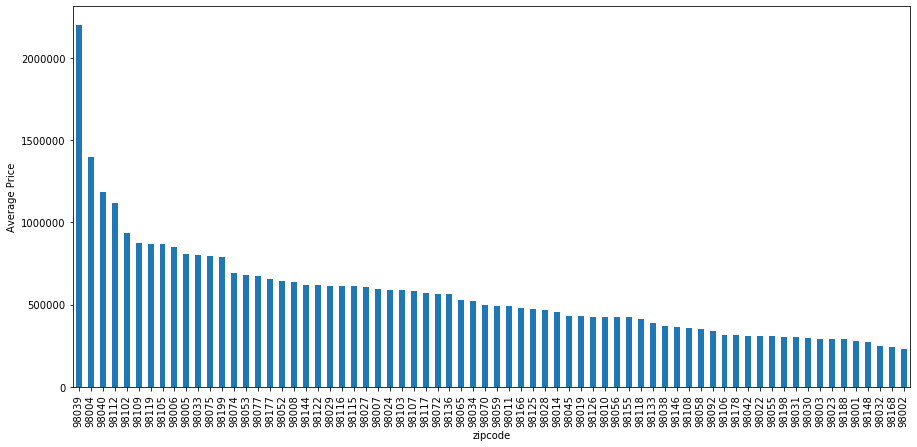

In [26]:
zip_means = df.groupby(['zipcode']).price.mean().sort_values(ascending=False)
plt.figure(figsize=(15,7))
plt.ylabel('Average Price')
zip_means.plot(kind='bar')

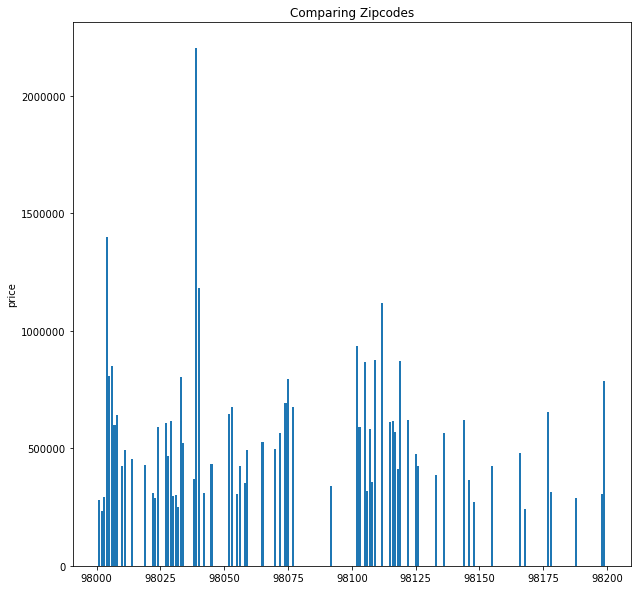

In [27]:
# Improve this visual
plt.figure(figsize=(10,10))
y = df.groupby('zipcode')['price'].mean()
x = y.index
plt.title("Comparing Zipcodes")
plt.ylabel("price")
plt.bar(x,y)
plt.show()

## Floors

Text(0.5, 0, 'Floors')

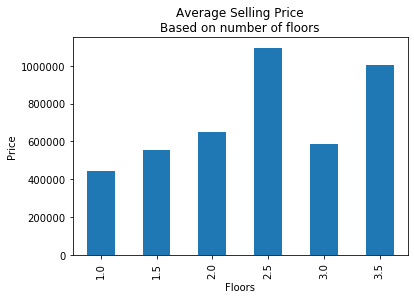

In [28]:
#Barplot Price v number of floors
df.groupby('floors')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on number of floors', size=12)
plt.ylabel('Price')
plt.xlabel('Floors')

In [29]:
df['floors_x_sqft_living'] = df['floors']*df['sqft_living']


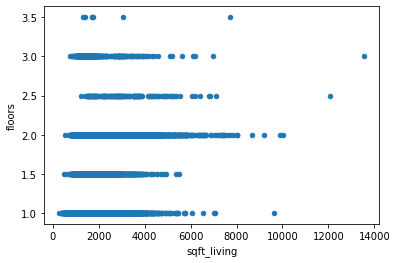

In [30]:
df.plot(kind='scatter', x='sqft_living', y='floors')

In [31]:
#df = df.drop(['floors_x_sqft_living'], axis=1)

### Strong correlations
- cap square foot living
- Checking for outliers and trends in grade, bathrooms, sqft_living, sqft_above, sqft_living15

In [32]:
cols = ['bathrooms', 'sqft_living', 'grade', 'sqft_living15', 'price']
#break the colums in to groups to plot 4 on a row at a time
n = 5
row_groups= [cols[i:i+n] for i in range(0, len(cols), n) ]

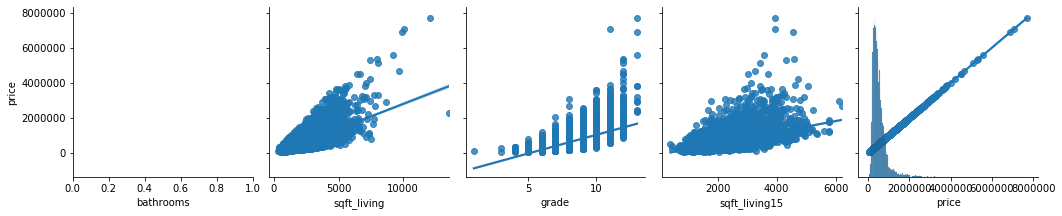

In [33]:
for i in row_groups:
    pp = sns.pairplot(data=df[cols], y_vars='price',x_vars=i, kind="reg", height=3)

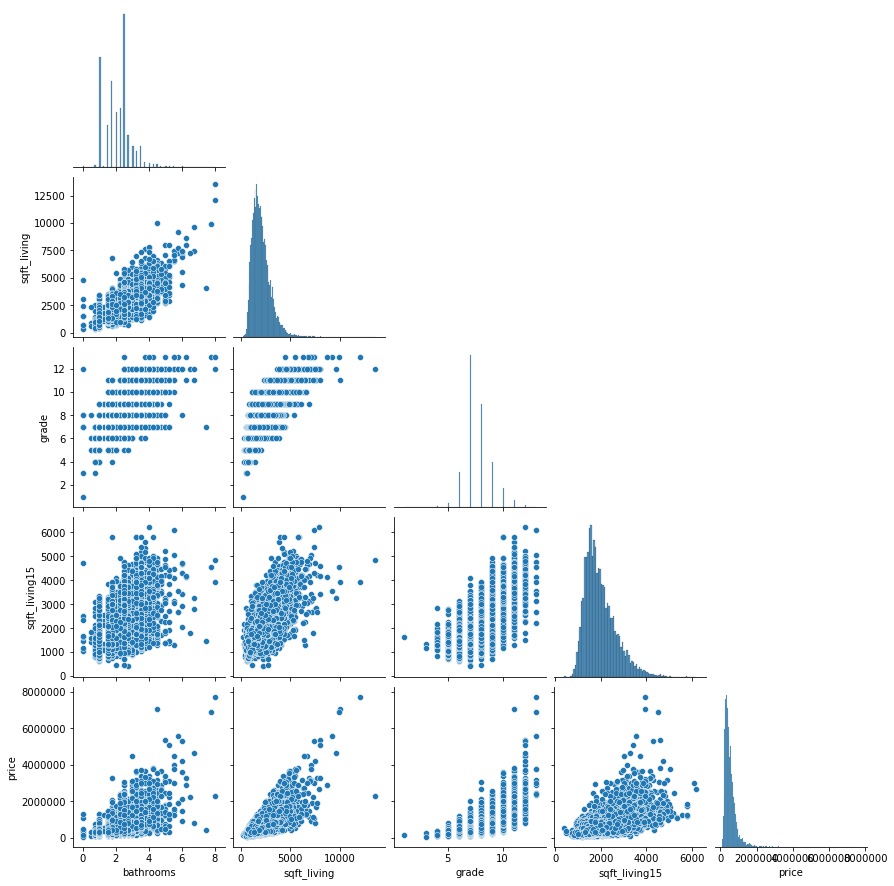

In [34]:
sns.pairplot(df[['bathrooms', 'sqft_living', 'grade', 'sqft_living15', 'price']], corner=True)

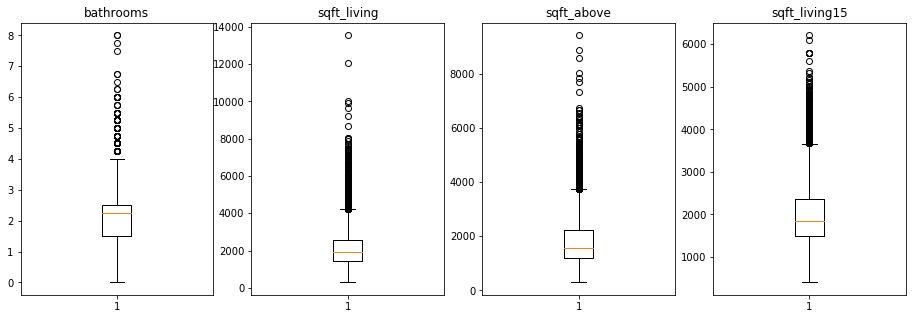

In [35]:
plt.figure(figsize=(20,5))

# ax3 = plt.subplot(1, 5, 1)
# plt.boxplot(df.grade)
# ax3.set_title('grade')

ax1 = plt.subplot(1, 5, 2)
plt.boxplot(df.bathrooms)
ax1.set_title('bathrooms')

ax2 = plt.subplot(1, 5, 3)
plt.boxplot(df.sqft_living)
ax2.set_title('sqft_living')


ax3 = plt.subplot(1, 5, 4)
plt.boxplot(df.sqft_above)
ax3.set_title('sqft_above')

ax3 = plt.subplot(1, 5, 5)
plt.boxplot(df.sqft_living15)
ax3.set_title('sqft_living15')

plt.show()

### 1. Bathrooms

Text(0.5, 0, 'Bathrooms')

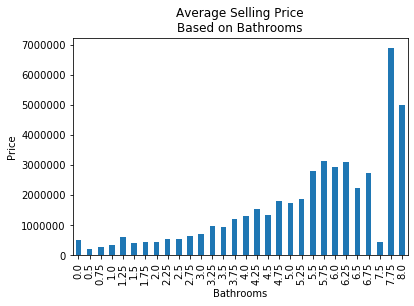

In [36]:
#Barplot Price v Bathrooms
df.groupby('bathrooms')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on Bathrooms', size=12)
plt.ylabel('Price')
plt.xlabel('Bathrooms')

In [37]:
# #Run model without this parameter first
# df['bathrooms'] = np.where(df.bathrooms>6, 6, df['bathrooms'])

In [38]:
df.bathrooms.value_counts()

2.50    4322
1.00    3100
1.75    2431
2.25    1666
2.00    1549
1.50    1168
2.75     896
3.00     592
3.50     591
3.25     455
3.75     135
4.00     107
4.50      76
4.25      64
0.75      52
5.00      17
4.75      16
5.25      11
0.00       8
5.50       7
1.25       6
6.00       6
5.75       3
0.50       3
8.00       2
6.75       2
6.25       2
7.50       1
6.50       1
7.75       1
Name: bathrooms, dtype: int64

Text(0.5, 0, 'Bathrooms')

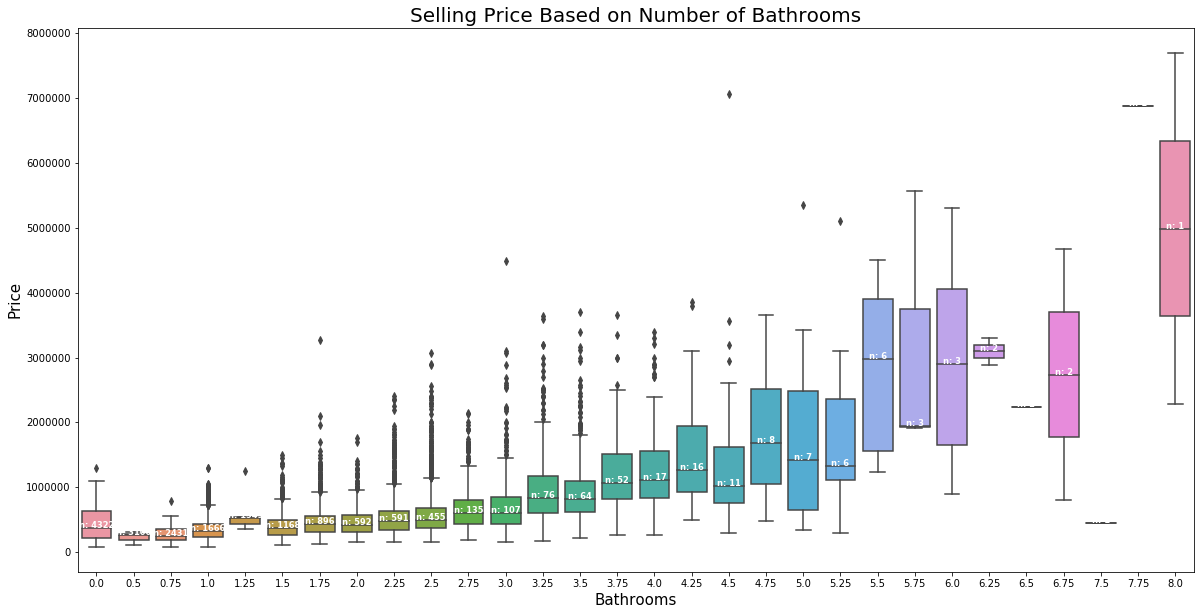

In [39]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x=df['bathrooms'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['bathrooms'])['price'].median().values
nobs = df['bathrooms'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
plt.title('Selling Price Based on Number of Bathrooms', size=20)
plt.ylabel('Price', size=15)
plt.xlabel('Bathrooms', size=15)

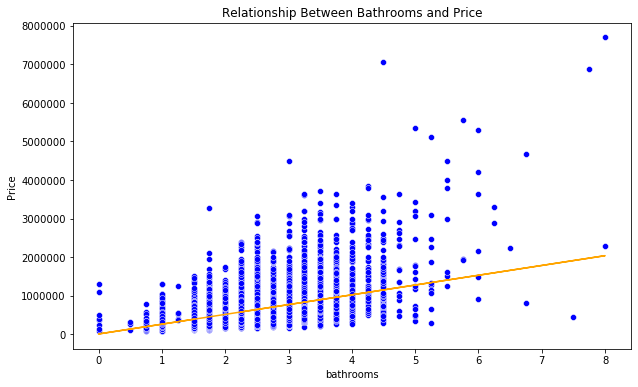

In [40]:
plt.subplots(figsize = (10,6))
ax = sns.scatterplot(x="bathrooms", y="price", data=df, color = 'blue')
ax.set(xlabel="bathrooms", ylabel = "Price", title="Relationship Between Bathrooms and Price")
x=df["bathrooms"]
y=df["price"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color = 'orange')

### 2. Grade - Construction Rating

Text(0.5, 0, 'Building and Construction Rating')

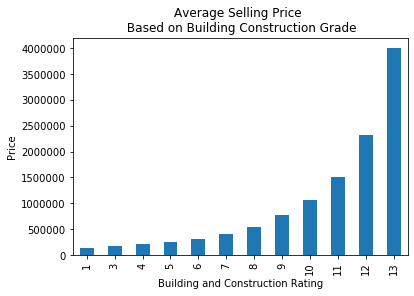

In [41]:
#Barplot Price v Grade
df.groupby('grade')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price \n Based on Building Construction Grade', size=12)
plt.ylabel('Price')
plt.xlabel('Building and Construction Rating')

### 3. Square Foot Living

In [42]:
df.sort_values('sqft_living')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,price_by_sqft,floors_x_sqft_living
10067,142000.0,0,0.00,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850,2014,9,489.655172,290.0
7263,276000.0,1,0.75,370,1801,1.0,0,0,5,5,370,0,1923,0,98117,47.6778,-122.389,1340,5000,2014,7,745.945946,370.0
2430,265000.0,0,0.75,384,213444,1.0,0,0,3,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341,2014,10,690.104167,384.0
13989,228000.0,0,1.00,390,5900,1.0,0,0,2,4,390,0,1953,0,98118,47.5260,-122.261,2170,6000,2014,10,584.615385,390.0
6345,245000.0,1,1.00,390,2000,1.0,0,0,4,6,390,0,1920,0,98103,47.6938,-122.347,1340,5100,2015,5,628.205128,390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15816,4668000.0,5,6.75,9640,13068,1.0,1,4,3,12,4820,4820,1983,2009,98040,47.5570,-122.210,3270,10454,2014,6,484.232365,9640.0
7519,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730,2014,9,696.157735,19780.0
6903,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449,2014,6,703.436255,20080.0
10366,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,2014,10,639.004149,30125.0


In [43]:
above_6std = df.price.mean()+(6*df.sqft_living.std())
above_6std

546259.6598772238

In [44]:
above_6std = df.price.mean()+(6*df.sqft_above.std())
above_6std

545715.1392829734

## Suprisingly weak correlations
- 'bedrooms', 'waterfront', 'view', 'condition', ('renovated_0' for later)

In [45]:
#Run below cell for pairplot

In [46]:
# sns.pairplot(df[['bathrooms', 'sqft_living', 'grade', 'sqft_living15', 'price']], corner=True)
# plt.show()

## Bedrooms
poly3, cat, or normal?

Text(0.5, 0, 'Bedrooms')

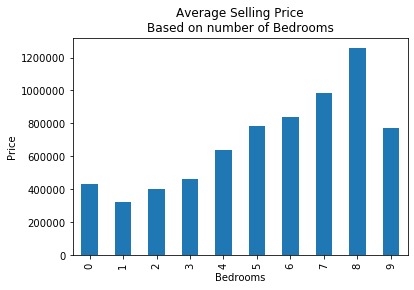

In [47]:
#Barplot Price v number of floors
df.groupby('bedrooms')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on number of Bedrooms', size=12)
plt.ylabel('Price')
plt.xlabel('Bedrooms')

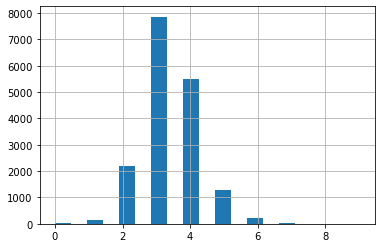

In [48]:
df.bedrooms.hist(bins=19)
plt.show()

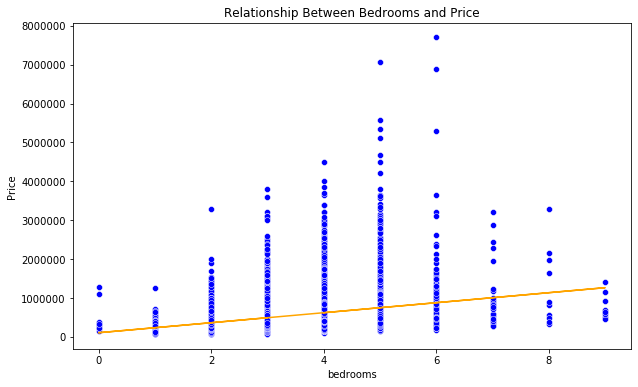

In [49]:
plt.subplots(figsize = (10,6))
ax = sns.scatterplot(x="bedrooms", y="price", data=df, color = 'blue')
ax.set(xlabel="bedrooms", ylabel = "Price", title="Relationship Between Bedrooms and Price")
x=df["bedrooms"]
y=df["price"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color = 'orange')

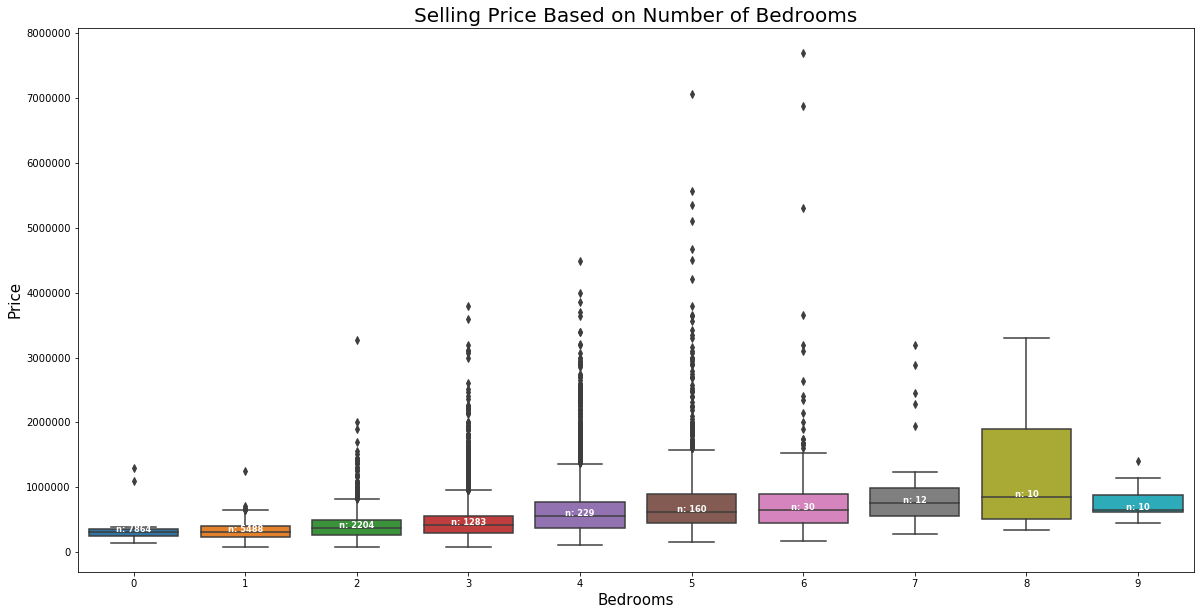

In [50]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x=df['bedrooms'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['bedrooms'])['price'].median().values
nobs = df['bedrooms'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
plt.title('Selling Price Based on Number of Bedrooms', size=20)
plt.ylabel('Price', size=15)
plt.xlabel('Bedrooms', size=15)

plt.show()

## Waterfront

Text(0.5, 0, 'Waterfront Property')

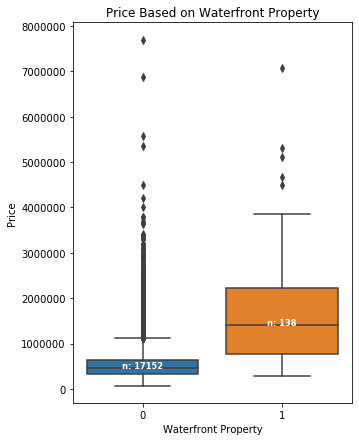

In [51]:
## Boxplot of Waterfront v. Price
plt.figure(figsize=(5,7))
ax = sns.boxplot(x=df['waterfront'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['waterfront'])['price'].median().values
nobs = df['waterfront'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
plt.title('Price Based on Waterfront Property')
plt.ylabel('Price')
plt.xlabel('Waterfront Property')

## View

Text(0.5, 0, 'View')

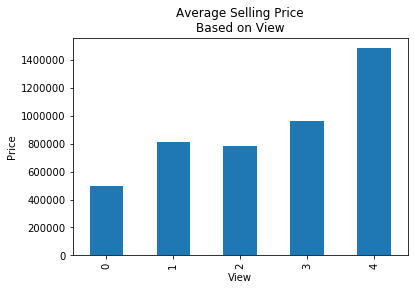

In [52]:
#Barplot Price v number of floors
df.groupby('view')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on View', size=12)
plt.ylabel('Price')
plt.xlabel('View')

Text(0.5, 0, 'View Rating')

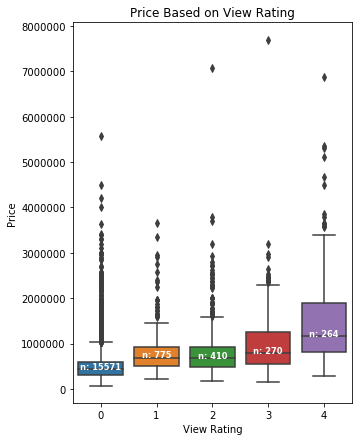

In [53]:
## Boxplot of View v. Price
plt.figure(figsize=(5,7))
ax = sns.boxplot(x=df['view'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['view'])['price'].median().values
nobs = df['view'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
plt.title('Price Based on View Rating')
plt.ylabel('Price')
plt.xlabel('View Rating')

## Condition

Text(0.5, 0, 'Condition')

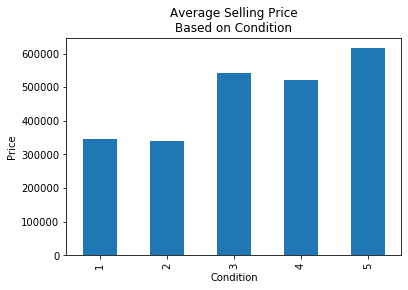

In [54]:
#Barplot Price v number of floors
df.groupby('condition')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price\nBased on Condition', size=12)
plt.ylabel('Price')
plt.xlabel('Condition')

Text(0.5, 0, 'Condition Quality')

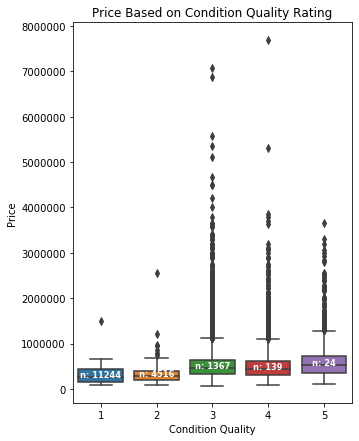

In [55]:
## Boxplot of Condition v. Price
plt.figure(figsize=(5,7))
ax = sns.boxplot(x=df['condition'], y=df['price'], data=df)
 
# Calculate number of obs per group & median to position labels
medians = df.groupby(['condition'])['price'].median().values
nobs = df['condition'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
horizontalalignment='center', size='small', color='w', weight='semibold')
    
# Set labels
plt.title('Price Based on Condition Quality Rating')
plt.ylabel('Price')
plt.xlabel('Condition Quality')

Text(0.5, 0, 'Condition')

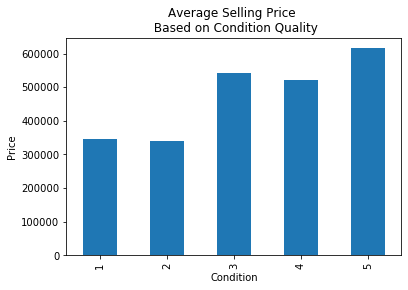

In [56]:
#Barplot Average Price v Condition Rating
df.groupby('condition')['price'].mean().plot(kind='bar')

#Set labels
plt.title('Average Selling Price \n Based on Condition Quality', size=12)
plt.ylabel('Price')
plt.xlabel('Condition')

In [57]:
# separate condition into 3 categories: 1/2, 3/4, and 5

# condition = [
#     (df.condition.values == 1) & (df.condition.values == 2),
#     (df.condition.values == 3) & (df.condition.values == 4),
#     (df.condition.values == 5)]

# choices = [
#     1, 
#     2, 
#     3,]

# df.conditions = np.select(conditions, choices, default='NA')

In [58]:
## RUN CELL ONCE
#Create dummy columns using 'condition2'
# df = pd.get_dummies(df, columns=['condition'])

# Step 3: Clean
- already took care of bedroom outliers with Read-In
- reining in square footage outliers
- work on binning 
    - `condition` into 3 categories: 1/2, 3/4, and 5
    - `view` into 3 categories: 0, 1&2, 3, 4 (or create poly?)

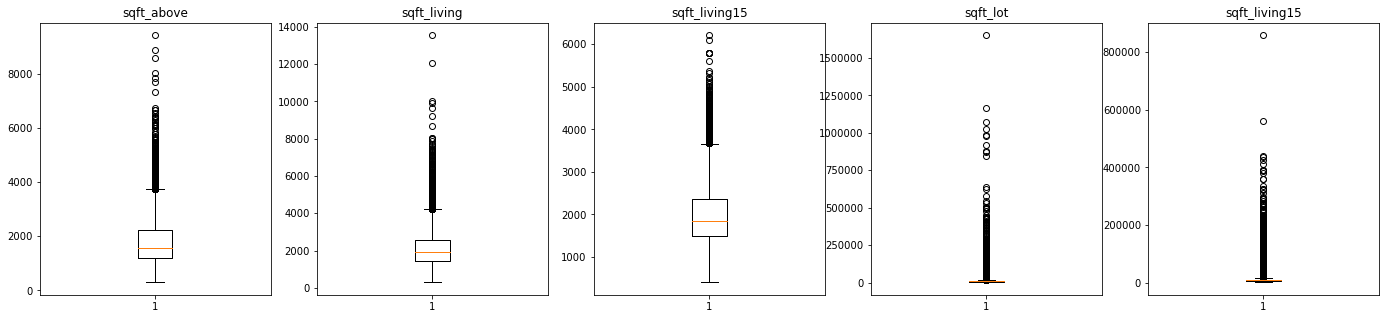

In [59]:
# Investigating Square footage outliers

plt.figure(figsize=(24,5))

ax3 = plt.subplot(1, 5, 1)
plt.boxplot(df.sqft_above)
ax3.set_title('sqft_above')

ax1 = plt.subplot(1, 5, 2)
plt.boxplot(df.sqft_living)
ax1.set_title('sqft_living')

ax2 = plt.subplot(1, 5, 3)
plt.boxplot(df.sqft_living15)
ax2.set_title('sqft_living15')


ax3 = plt.subplot(1, 5, 4)
plt.boxplot(df.sqft_lot)
ax3.set_title('sqft_lot')

ax3 = plt.subplot(1, 5, 5)
plt.boxplot(df.sqft_lot15)
ax3.set_title('sqft_living15')

plt.show()

In [60]:
# adjuting sqft home outliers to within 6 standard deviations of the mean
for col in ['sqft_above', 'sqft_living', 'sqft_living15']: 
    above_6std = df[col].mean()+(6*df[col].std())
    df[col] = np.where(df[col].values >above_6std, df[col].mean()+6*df[col].std(), df[col])
    
# adjusting lot outliers to within 9 standard deviations of the mean
for col in ['sqft_lot', 'sqft_lot15']: 
    above_9std = df[col].mean()+(9*df[col].std())
    df[col] = np.where(df[col].values >above_6std, df[col].mean()+9*df[col].std(), df[col])

# Try these to see if they improve model

In [61]:
# # Create Bins for Grade 1-4, 5-7, 8-13
# cut_labels1 = [1, 2, 3]
# cut_bins1 = [0, 4, 7, 13]
# df['cut_grade'] = pd.cut(df['grade'], bins=cut_bins2, labels=cut_labels2)
# df['cut_grade'] = pd.to_numeric(df['cut_grade'],errors='coerce')

In [62]:
# # Create Bins for Condition 1-2, 3-4, 5
# cut_labels2 = [1, 2, 3]
# cut_bins2 = [0, 2, 4, 5]
# df['cut_condition'] = pd.cut(df['condition'], bins=cut_bins2, labels=cut_labels2)
# df['cut_condition'] = pd.to_numeric(df['condition'],errors='coerce')

In [63]:
# # Create Bins for View 0, 1-2, 3, 4
# cut_labels2 = [1, 2, 3, 4]
# cut_bins2 = [0, 2, 3, 4]
# df['cut_view'] = pd.cut(df['view'], bins=cut_bins2, labels=cut_labels2)
# df['cut_view'] = pd.to_numeric(df['cut_view'],errors='coerce')

In [64]:
# # Create Bins for Floors ## decide bins!!
# cut_labels2 = [1, 2, 3]
# cut_bins2 = [0, 4, 7, 13]
# df['cut_floors'] = pd.cut(df['floors'], bins=cut_bins2, labels=cut_labels2)
# df['cut_floors'] = pd.to_numeric(df['cut_floors'],errors='coerce')

# Step 4: Generate new features that you think could be important.

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

# Create new features with lat/long here!!

In [65]:
## RUN THIS CELL ONLY ONCE!

#Create new column 'age' for age of house
df['age'] = 2020 - df.yr_built

#Create dummy variable 'basement' y/n
df['basement'] = np.where(df['sqft_basement']>0 , 1, 0)
df = pd.get_dummies(df, columns=['basement'])
df = df.drop(['basement_0'], axis=1)

#Create a new column 'neighbors_compared' with sqft_living - sqft_living15
df['neighbors_compared'] = df.sqft_living - df.sqft_living15

#Create dummy columns using 'nc_2'
df['nc2'] = np.where(df['sqft_living']> df['sqft_living15'] , 1, 0)
df = pd.get_dummies(df, columns=['nc2'])
df = df.drop(['nc2_0'], axis=1)


Playing with `renovated` columns:

In [66]:
#Create new column 'last_renovted' for how long ago since last renovation
df['last_ren'] = np.where(df['yr_renovated'] > 0, (2020 - df['yr_renovated']), 0) ##np.nan may break this code... find out a way to make '0' into null value

#Create new column 'last_ren2' for how long (years) since last renovation and including age if no renovation
df['last_ren2'] = np.where(df['yr_renovated'] > 0, (2020 - df['yr_renovated']), (2020 - df['yr_built']))

#Create dummy columns using 'renovated'
df['renovated'] = np.where(df['yr_renovated']>0 , 1, 0)
df = pd.get_dummies(df, columns=['renovated'])
df = df.drop(['renovated_0'], axis=1)

#### Create dummy zip codes

In [67]:
# from sklearn.preprocessing import OneHotEncoder

# cat_encoder = OneHotEncoder() #instantiate
# housing_cat_1hot = cat_encoder.fit_transform(housing_cat) #fit & transform 'x' variables 'housing_cat'

# housing_cat_1hot #output is a sparse matrix
# # optional to change matrix to array:
# housing_cat_1hot.toarray()

# # Add columns back together with np.c_
# X = np.c_[(housing_num, housing_cat_1hot.toarray())]

In [68]:
# # Create dummy variables for zipcode
# zip_dummies = pd.get_dummies(df['zipcode'].astype(str), dtype=int, drop_first=True)
# df.drop(columns=['zipcode'],inplace=True)
# zips = 'zip'+zip_dummies.columns
# zip_dummies.columns = zips
# zip_dummies.head()

In [69]:
# Create dummy variables for zipcodes
zip_dummies = pd.get_dummies(df['zipcode'], drop_first=True)
#df.drop(columns=['zipcode'],inplace=True)
#zips = 'zip'+zip_dummies.columns
# zip_dummies.columns = zips
# zip_dummies.head()

In [70]:
zip_dummies

,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17286,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17287,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17288,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
#below 2 cells using OneHotEncoder

In [72]:
# from sklearn.preprocessing import OneHotEncoder

# cat_encoder = OneHotEncoder() #instantiate
# housing_cat_1hot = cat_encoder.fit_transform(housing_cat) #fit & transform 'x' variables 'housing_cat'

# housing_cat_1hot #output is a sparse matrix
# # optional to change matrix to array:
# housing_cat_1hot.toarray()

# # Add columns back together with np.c_
# X = np.c_[(housing_num, housing_cat_1hot.toarray())]

In [73]:
# # Add to cat_encoder to dataframe
# cols = housing_num.columns.tolist() + cat_encoder.categories_[0].tolist()
# housing_tr = pd.DataFrame(X, columns=cols)

# housing_tr.head() #new DF!

## Checking on new features

In [74]:
#Run below cell for correlation matrix

In [75]:
# # Correlation matrix
# fig, ax = plt.subplots(figsize=(20, 15))

# corr = df.corr()

# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# # fix for matplotlib bug that cuts off top/bottom of seaborn viz
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values

# plt.show()

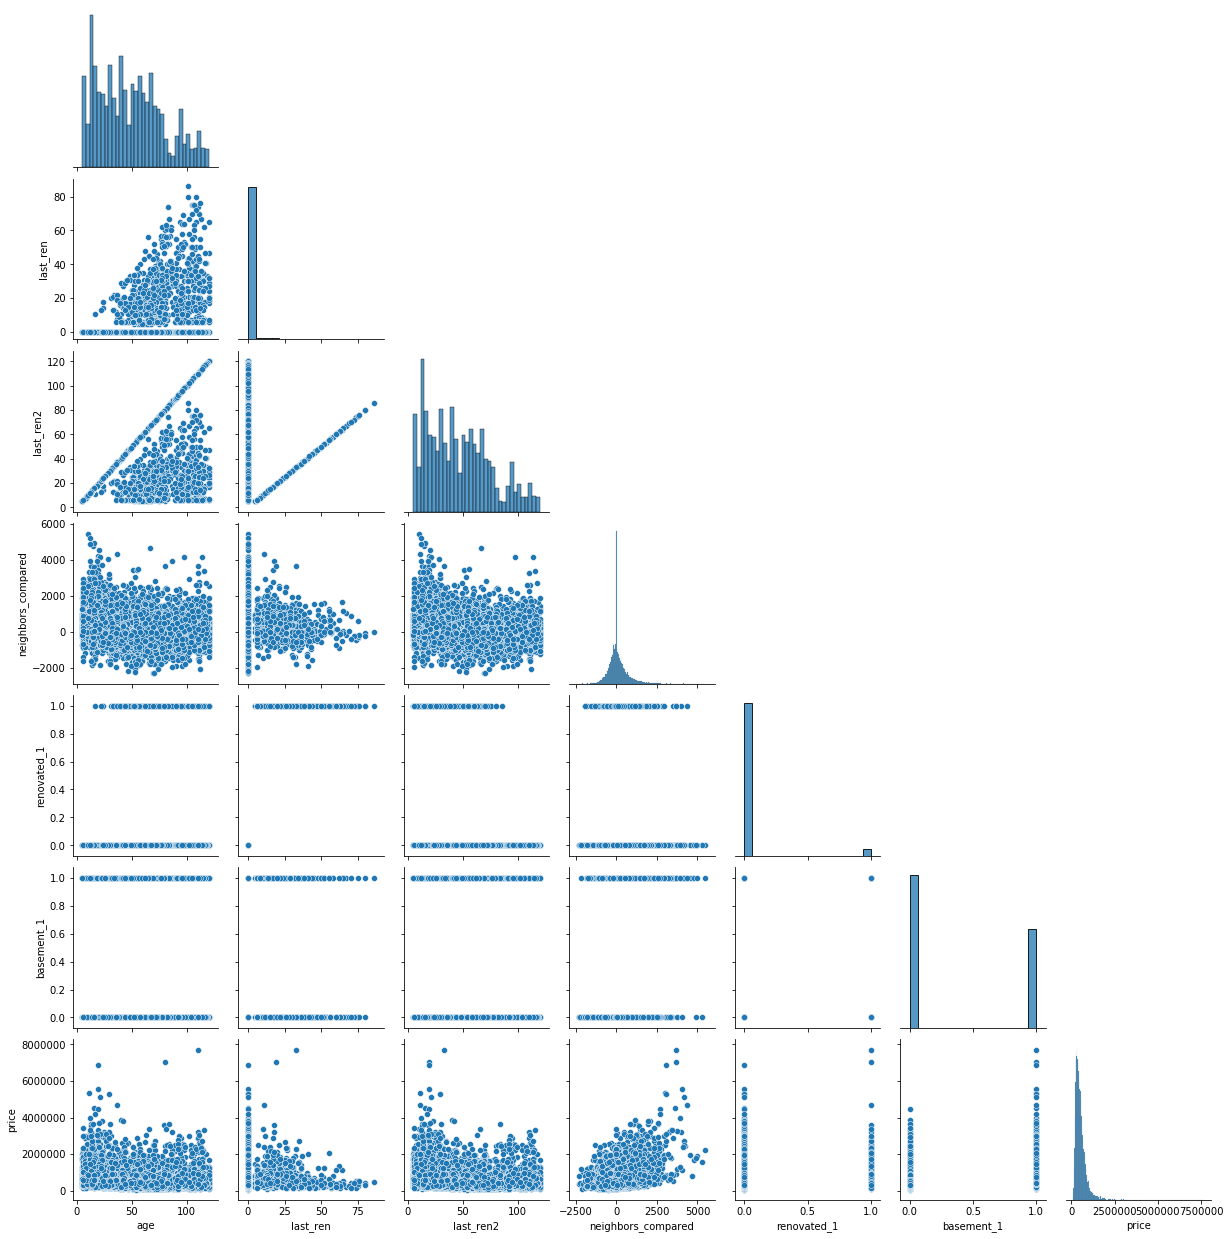

In [76]:
# #Checking on new features
# sns.pairplot(df[['age', 'last_ren', 'last_ren2', 'neighbors_compared', 'renovated_1', 'basement_1', 'price']], corner=True)


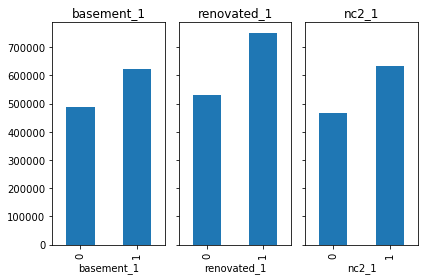

In [77]:
# # Create bar plots
# fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)

# categoricals = ['basement_1', 'renovated_1', 'nc2_1']

# for col, ax in zip(categoricals, axes.flatten()):
#     (df.groupby(col).mean()['price']
#          .sort_values()              # sort the groups in ascending order if desired
#          .plot.bar(ax=ax))
#     ax.set_title(col)
# fig.tight_layout()

In [78]:
# Concat df and zip dummies DFs
df = pd.concat([df, zip_dummies], axis=1)

### 4.1) Identify a categorical variable in the data set and create dummy columns.
- condition, view, bathrooms, bedrooms, floors, zipcode

In [79]:
# your code here

### 4.2) There is a column that gives the date for when the house was sold, how could this be useful in your model? How might you transform the current column to a more useful feature?

In [80]:
#your code here

### 4.3) There are columns for when the house was built and when it was renovated.  How could you use these columns to create a new column?

In [81]:
#your code here 

### <ins>Non-linear transformations</ins>

### 4.4) Create a polynomial feature for two of your continuous variables.

In [82]:
#df.head() # Sanity Check to remove dummy variables

In [83]:
list(df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'yr_sold',
 'month_sold',
 'price_by_sqft',
 'floors_x_sqft_living',
 'age',
 'basement_1',
 'neighbors_compared',
 'nc2_1',
 'last_ren',
 'last_ren2',
 'renovated_1',
 98002,
 98003,
 98004,
 98005,
 98006,
 98007,
 98008,
 98010,
 98011,
 98014,
 98019,
 98022,
 98023,
 98024,
 98027,
 98028,
 98029,
 98030,
 98031,
 98032,
 98033,
 98034,
 98038,
 98039,
 98040,
 98042,
 98045,
 98052,
 98053,
 98055,
 98056,
 98058,
 98059,
 98065,
 98070,
 98072,
 98074,
 98075,
 98077,
 98092,
 98102,
 98103,
 98105,
 98106,
 98107,
 98108,
 98109,
 98112,
 98115,
 98116,
 98117,
 98118,
 98119,
 98122,
 98125,
 98126,
 98133,
 98136,
 98144,
 98146,
 98148,
 98155,
 98166,
 98168,
 98177,
 98178,
 98188,
 98198,
 98199]

In [84]:
features = [
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'yr_sold',
 'month_sold',
 'price_by_sqft',
 'floors_x_sqft_living',
 'age',
 'neighbors_compared',
 'last_ren2',
 'renovated_1']
df_features = df[features]
target = df['price']

In [85]:
# your code here
poly_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yr_sold', 'month_sold',
       'age', 'last_ren2', 'neighbors_compared']

poly2_features = pd.DataFrame()
poly3_features = pd.DataFrame()

for feat in poly_cols:
    poly2_features[feat+'^2'] = df[feat]**2
for feat in poly_cols:    
    poly3_features[feat+'^3'] = df[feat]**3
    

In [86]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,month_sold,price_by_sqft,floors_x_sqft_living,age,basement_1,neighbors_compared,nc2_1,last_ren,last_ren2,renovated_1,98002,98003,98004,98005,98006,98007,98008,98010,98011,98014,98019,98022,98023,98024,98027,98028,98029,98030,98031,98032,98033,98034,98038,98039,98040,98042,98045,98052,98053,98055,98056,98058,98059,98065,98070,98072,98074,98075,98077,98092,98102,98103,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,365000.0,4,2.25,2070.0,395985.013979,2.0,0,0,4,8,2070.0,0,1986,0,98058,47.4388,-122.162,2390.0,257920.414075,2014,10,176.328502,4140.0,34,0,-320.0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,865000.0,5,3.00,2900.0,395985.013979,1.0,0,0,5,8,1830.0,1070,1977,0,98115,47.6784,-122.285,2370.0,257920.414075,2014,8,298.275862,2900.0,43,1,530.0,1,0,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1038000.0,4,2.50,3770.0,395985.013979,2.0,0,2,3,11,3770.0,0,1997,0,98006,47.5646,-122.129,3710.0,257920.414075,2014,8,275.331565,7540.0,23,0,60.0,1,0,23,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1490000.0,3,3.50,4560.0,395985.013979,2.0,0,2,3,12,4560.0,0,1990,0,98034,47.6995,-122.228,4050.0,257920.414075,2015,3,326.754386,9120.0,30,0,510.0,1,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,711000.0,3,2.50,2550.0,5376.000000,2.0,0,0,3,9,2550.0,0,2004,0,98052,47.6647,-122.083,2250.0,4050.000000,2014,7,278.823529,5100.0,16,0,300.0,1,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable.

In [87]:
# your code here

# Step 5: Train-Test Split

### 5.1) Perform a train-test split of the data.

This code will need to be re-run with list(df.columns) if features are added

In [89]:
# df.head() #Sanity Check

In [90]:
## Why doesn't iloc work here??

# features = df.iloc[:,1:]
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yr_sold', 'month_sold',
       'age', 'last_ren', 'last_ren2', 'renovated_1', 'basement_1',
       'neighbors_compared', 'nc2_1']
df_features = df[features]
target = df['price']

In [91]:
## Why doesn't iloc work here??

# features = df.iloc[:,1:]
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yr_sold', 'month_sold',
       'age', 'last_ren', 'last_ren2', 'renovated_1', 'basement_1',
       'neighbors_compared', 'nc2_1']
df_features = df[features]
target = df['price']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=42,test_size=0.2)

#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (13832, 26) Target:  (13832,)
Training set - Features:  (3458, 26) Target:  (3458,)


# Log
- LOG Training RMSE: 186,982
- LOG Testing RMSE:  182,801

after edits:
- LOG Training RMSE: 110802
- LOG Testing RMSE:  164965
- 
#### Poly 3 With Lasso - DOUBLE CHECK THESE VALUES!
- Training RMSE: 94,810
- Testing RMSE: 191,460

In [95]:
y_log = np.log(y_train)

# instantiate a linear regression object and fit
lm_log = LinearRegression()
lm_log = lm_log.fit(X_train, y_log)

In [96]:
log_train_pred = lm_log.predict(X_train)

# exponentiate the predictions to get them on the same original scale 
y_train_pred = np.exp(log_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('LOG Training Root Mean Squared Error:' , train_rmse)

LOG Training Root Mean Squared Error: 186982.52389380237


In [97]:
log_test_pred = lm_log.predict(X_test)

# exponentiate the predictions to get them on the same original scale 
log_test_pred = np.exp(log_test_pred)
log_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, log_test_pred))

print('LOG Training Root Mean Squared Error:' , train_rmse)
print('LOG Testing Root Mean Squared Error: ' , log_test_rmse)

LOG Training Root Mean Squared Error: 186982.52389380237
LOG Testing Root Mean Squared Error:  182801.72298284297


In [98]:
# Checking mae vs rmse
metrics.mean_absolute_error(y_train, y_train_pred) 

108494.02704646341

In [99]:
#If we decide to use Log, run this cell!!

# reassign y_test_pred to our log model
y_test_pred = lm_log.predict(X_test)

#our model predicted the log of gross, so now we must exponentiate to get value back in $
y_test_pred = np.exp(y_test_pred)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

#print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Training:  186982 vs. Testing:  182801


# Polynomial Features

## Poly 2

#### with Log, no feature selection
- Training RMSE:  151,662
- Testing RMSE: 528,977

#### with Log and Lasso -
- Poly2 Training RMSE: 106,307
- Poly2 Testing RMSE: 177,626

after zips
- Training RMSE: 79,093
- **Testing RMSE: 138,793 *Best**

#### Poly with Log and Kbest (83 features)
- KBEST Training RMSE: 171,302
- KBEST Testing RMSE: 170,581

without Log, with Kbest?

#### Poly with Log and RFE (after zips)
- RFE Training RMSE: 179,763
- RFE Testing RMSE: 170,627

##### with log, no feature selection

In [100]:
## Why doesn't iloc work here??

# features = df.iloc[:,1:]
poly_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yr_sold', 'month_sold',
       'age', 'last_ren', 'last_ren2', 'renovated_1', 'basement_1',
       'neighbors_compared', 'nc2_1']
poly_features = df[poly_features]
target = df['price']

In [101]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(poly_features)
poly2_columns = poly_2.get_feature_names(poly_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
#df_poly2.head() #Sanity Check

In [102]:
# Concat dfs together to test
df_poly2 = pd.concat([df_poly2, zip_dummies], axis=1)
# df_poly2.head()

In [103]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, target, random_state=42,test_size=0.2)

In [104]:
# instantiate a linear regression object and fit to training data
lm_2 = LinearRegression()
lm_2 = lm_2.fit(X_train, y_train)

y_train_pred = lm_2.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 119022.94621067109


In [105]:
# use fitted model to predict on test data
y_pred = lm_2.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 463905.1936485203
Training:  119022 vs. Testing:  463905


##### Poly2 Lasso with Log (remember to scale)
- Training Error: 106307
- Testing Error: 177626

after zips added:
- Training Error: 79093
- Testing Error: 138793

In [106]:
## training the model
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=.1, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred_lasso = lasso.predict(X_train)
y_pred_lasso = lasso.predict(X_test)

train_rmse_lasso01 = metrics.mean_absolute_error(y_train, y_train_pred_lasso)
test_rmse_lasso01 = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
print('Training Error: '+ str(train_rmse_lasso01) )
print('Testing Error: '+ str(test_rmse_lasso01) )

Training Error: 79093.93386283012
Testing Error: 138793.69243896508


##### KBest with Log
20 variables
- Training Root Mean Squared Error: 192118
- Testing Root Mean Squared Error: 187339

83 variables
- KBEST Training Root Mean Squared Error: 171302
- KBEST Testing Root Mean Squared Error: 170581

Note: Run KBest without Log?

##### Poly2 log, KBest83 features
- KBEST Training Root Mean Squared Error: 171302
- KBEST Testing Root Mean Squared Error: 170581

did worse after zips added (28 features):
- KBEST Training Root Mean Squared Error: 193908
- KBEST Testing Root Mean Squared Error: 187826

In [107]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=28) # <----- number of features you want
selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.get_support()] #kept columns
removed_columns = X_train.columns[~selector.get_support()] #removed columns
list(selected_columns)
#list(removed_columns)

['sqft_living',
 'grade',
 'bedrooms sqft_living',
 'bathrooms sqft_living',
 'bathrooms grade',
 'bathrooms sqft_above',
 'bathrooms sqft_living15',
 'sqft_living^2',
 'sqft_living floors',
 'sqft_living condition',
 'sqft_living grade',
 'sqft_living sqft_above',
 'sqft_living yr_built',
 'sqft_living lat',
 'sqft_living long',
 'sqft_living sqft_living15',
 'sqft_living yr_sold',
 'condition sqft_above',
 'grade^2',
 'grade sqft_above',
 'grade yr_built',
 'grade lat',
 'grade long',
 'grade sqft_living15',
 'grade yr_sold',
 'sqft_above^2',
 'sqft_above lat',
 'sqft_above sqft_living15']

In [108]:
len(selected_columns)

28

In [109]:
#instantiate a linear regression object and fit to train data
lm_kbest = LinearRegression()
lm_kbest.fit(X_train[selected_columns], y_train)

# Training Root Mean Squared Error
y_train_kbest = lm_kbest.predict(X_train[selected_columns])
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))
print('KBEST Training Root Mean Squared Error:' , trainK_rmse)

# Testing Root Mean Squared Error
y_kbest = lm_kbest.predict(X_test[selected_columns])
testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))
print('KBEST Testing Root Mean Squared Error:' , testK_rmse)

KBEST Training Root Mean Squared Error: 193908.69924537622
KBEST Testing Root Mean Squared Error: 187826.16331700908


##### RFE with Log
- Training RMSE: 201,630
- Testing RMSE: 197,283

after zips
- Training RMSE: 179,763
- Testing RMSE: 170,627

In [110]:
# from sklearn.feature_selection import RFECV

# ols = linear_model.LinearRegression()

# selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# # Fit recursive feature eliminator 
# selector.fit(X_train, y_train)

In [111]:
# selected_rfe = X_train.columns[selector.support_]
# removed_rfe = X_train.columns[~selector.support_]
# # list(selected_rfe)
# # list(removed_rfe)

In [112]:
# #instantiate a linear regression object and fit to train
# lm_rfe = LinearRegression()
# lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

# # Train
# y_rfe = lm_rfe.predict(X_train[selected_rfe])
# trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))
# print('Training Root Mean Squared Error:' , trainRFE_rmse)

# # Test
# y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])
# testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))
# print('Testing Root Mean Squared Error:' , testRFE_rmse)

## Poly 3
performs worse than Poly2
#### Poly3 Log with Lasso:
- Training RMSE: 94810
- Testing RMSE: 191460
#### Poly3 Log and KBest (86 features) *best before zips?
- KBEST Training RMSE: 170993
- KBEST Testing RMSE: 169767

after adding zips:
- KBEST Training RMSE 193787
- KBEST Testing RMSE: 187970

In [113]:
# poly_3 = PolynomialFeatures(degree=3, include_bias=False)
# poly3_data = poly_3.fit_transform(df_features)
# poly3_columns = poly_3.get_feature_names(df_features.columns)
# df_poly3 = pd.DataFrame(poly3_data, columns=poly3_columns)
# df_poly3.head()

In [114]:
# # Concat dfs together to test
# df_poly3 = pd.concat([df_poly3, zip_dummies], axis=1)
# #df_poly3.head()

##### Poly3 with Lasso

In [115]:
# poly_3 = PolynomialFeatures(degree=3, include_bias=False)
# poly3_data = poly_3.fit_transform(df_features)
# poly3_columns = poly_3.get_feature_names(df_features.columns)
# df_poly3 = pd.DataFrame(poly3_data, columns=poly3_columns)
# #df_poly3.head() #Sanity Check

In [116]:
# X_train, X_test, y_train, y_test = train_test_split(df_poly3, target, random_state=42,test_size=0.2)

In [117]:
# # instantiate a linear regression object and fit to training data
# lm_3 = LinearRegression()
# lm_3 = lm_2.fit(X_train, y_train)

# y_train_pred = lm_3.predict(X_train)

# train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
# print('Training Root Mean Squared Error:' , train_rmse)

In [118]:
# # use fitted model to predict on test data
# y_pred = lm_3.predict(X_test)

# test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

# print('Testing Root Mean Squared Error:' , test_rmse)
# print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

In [119]:
# lasso3 = Lasso(alpha=.1, normalize=False)

# lasso3.fit(X_train,y_train)

# y_train_pred_lasso3 = lasso3.predict(X_train)
# y_pred_lasso3 = lasso3.predict(X_test)

# train_rmse_lasso3 = metrics.mean_absolute_error(y_train, y_train_pred_lasso3)
# test_rmse_lasso3 = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso3))
# print('Training Error: '+ str(train_rmse_lasso01) )
# print('Testing Error: '+ str(test_rmse_lasso01) )

##### Poly3 KBest

In [120]:
# from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

# selector = SelectKBest(f_regression, k=31) # <----- f_regression and number of features you want
# selector.fit(X_train, y_train)

# selected_columns = X_train.columns[selector.get_support()] #kept columns
# removed_columns = X_train.columns[~selector.get_support()] #removed columns
# list(selected_columns)
# # list(removed_columns)

In [121]:
# #instantiate a linear regression object and fit to train data
# lm_kbest = LinearRegression()
# lm_kbest.fit(X_train[selected_columns], y_train)

# # Training Root Mean Squared Error
# y_train_kbest = lm_kbest.predict(X_train[selected_columns])
# trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))
# print('KBEST Training Root Mean Squared Error:' , trainK_rmse)

# # Testing Root Mean Squared Error
# y_kbest = lm_kbest.predict(X_test[selected_columns])
# testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))
# print('KBEST Testing Root Mean Squared Error:' , testK_rmse)

##### Poly3 RFE

In [122]:
# Run below cells only if you want computer to crash!:)

In [123]:
# from sklearn.feature_selection import RFECV
# ols = linear_model.LinearRegression()

# selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# # Fit recursive feature eliminator 
# selector.fit(X_train, y_train)

In [124]:
# selected_rfe = X_train.columns[selector.support_]
# removed_rfe = X_train.columns[~selector.support_]
# # list(selected_rfe)
# # list(removed_rfe)

In [125]:
# #instantiate a linear regression object and fit to train
# lm_rfe = LinearRegression()
# lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

# # Train
# y_rfe = lm_rfe.predict(X_train[selected_rfe])
# trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))
# print('Training Root Mean Squared Error:' , trainRFE_rmse)

# # Test
# y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])
# testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))
# print('Testing Root Mean Squared Error:' , testRFE_rmse)

# Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.

### 6.1) Utilize a filter method to identify some features to remove from the model.  

## Lasso

In [126]:
# ## training the model
# from sklearn.linear_model import Lasso

# lasso = Lasso(alpha=.1, normalize=False)

# lasso.fit(X_train,y_train)

# y_train_pred_lasso = lasso.predict(X_train)
# y_pred_lasso = lasso.predict(X_test)

# train_rmse_lasso01 = metrics.mean_absolute_error(y_train, y_train_pred_lasso)
# test_rmse_lasso01 = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
# print('Training Error: '+ str(train_rmse_lasso01) )
# print('Testing Error: '+ str(test_rmse_lasso01) )

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

In [127]:
# your code here

# Step 7: Evaluate your different models in order to determine the best model overall.

# Step 8:  Refit your best model to the entire dataset.

In [128]:
# # Poly2 model
# selector = SelectKBest(f_regression, k=83) # <----- number of features you want
# selector.fit(df_poly2, target)

# selected_columns = X_train.columns[selector.get_support()] #kept columns
# removed_columns = X_train.columns[~selector.get_support()] #removed columns

In [129]:
# # Poly3 model
# selector = SelectKBest(f_regression, k=86) # <----- f_regression and number of features you want
# selector.fit(df_poly3, target)

# selected_columns = X_train.columns[selector.get_support()] #kept columns
# removed_columns = X_train.columns[~selector.get_support()] #removed columns

In [130]:
#instantiate a linear regression object
lm_final = LinearRegression()

#fit the linear regression to the data
lm_final = lm_final.fit(df_poly2[selected_columns], target)

In [131]:
list(selected_columns)

['sqft_living',
 'grade',
 'bedrooms sqft_living',
 'bathrooms sqft_living',
 'bathrooms grade',
 'bathrooms sqft_above',
 'bathrooms sqft_living15',
 'sqft_living^2',
 'sqft_living floors',
 'sqft_living condition',
 'sqft_living grade',
 'sqft_living sqft_above',
 'sqft_living yr_built',
 'sqft_living lat',
 'sqft_living long',
 'sqft_living sqft_living15',
 'sqft_living yr_sold',
 'condition sqft_above',
 'grade^2',
 'grade sqft_above',
 'grade yr_built',
 'grade lat',
 'grade long',
 'grade sqft_living15',
 'grade yr_sold',
 'sqft_above^2',
 'sqft_above lat',
 'sqft_above sqft_living15']

## Checking model attributes to copy to holdout notebook

In [132]:
list(df_poly2[selected_columns].columns)

['sqft_living',
 'grade',
 'bedrooms sqft_living',
 'bathrooms sqft_living',
 'bathrooms grade',
 'bathrooms sqft_above',
 'bathrooms sqft_living15',
 'sqft_living^2',
 'sqft_living floors',
 'sqft_living condition',
 'sqft_living grade',
 'sqft_living sqft_above',
 'sqft_living yr_built',
 'sqft_living lat',
 'sqft_living long',
 'sqft_living sqft_living15',
 'sqft_living yr_sold',
 'condition sqft_above',
 'grade^2',
 'grade sqft_above',
 'grade yr_built',
 'grade lat',
 'grade long',
 'grade sqft_living15',
 'grade yr_sold',
 'sqft_above^2',
 'sqft_above lat',
 'sqft_above sqft_living15']

In [133]:
len(lm_final.coef_)

28

# Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [1]:
# import pickle

# #Model
# pickle_out = open("poly2_model.pickle","wb")
# pickle.dump(lm_final, pickle_out)
# pickle_out.close()

NameError: name 'lm_final' is not defined